# Finding Similar Items

In [14]:
import html
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import unicodedata
import zipfile

## Loading the Data

In [15]:
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

if not os.path.exists(os.path.join(kaggle_dir, "kaggle.json")):
    print("Please upload your kaggle.json manually or place it in ~/.kaggle")

os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews

with zipfile.ZipFile("amazon-books-reviews.zip", "r") as zip_ref:
    zip_ref.extractall("data")  # output folder = ./data

csv_path = os.path.join("data", "Books_rating.csv") 
df = pd.read_csv(csv_path)

df.head()

/Users/hilalmente/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
amazon-books-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


## Missing Values, Empty Strings, and Short Reviews

In [16]:
missing_count = df["review/text"].isna().sum()
empty_strings = (df["review/text"].fillna("").str.strip() == "").sum()
short_reviews = df["review/text"].fillna("").apply(lambda x: len(str(x).split()) <= 3).sum()

print(f"Number of NaN: {missing_count}")
print(f"Number of Empty string: {empty_strings}")
print(f"Number of very short strings (≤ 3 words): {short_reviews}")

Number of NaN: 8
Number of Empty string: 8
Number of very short strings (≤ 3 words): 864


## Exploratory Data Analysis on Review Lengths

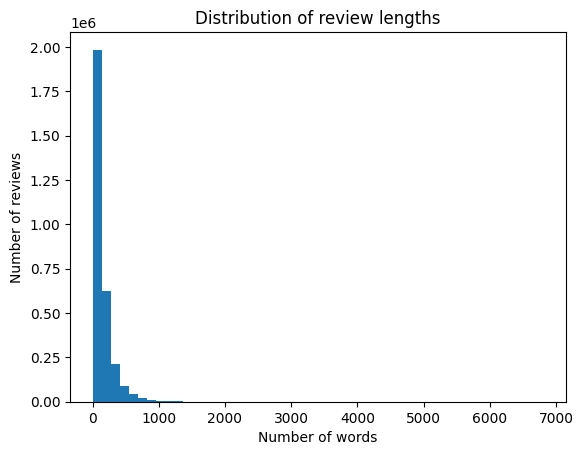

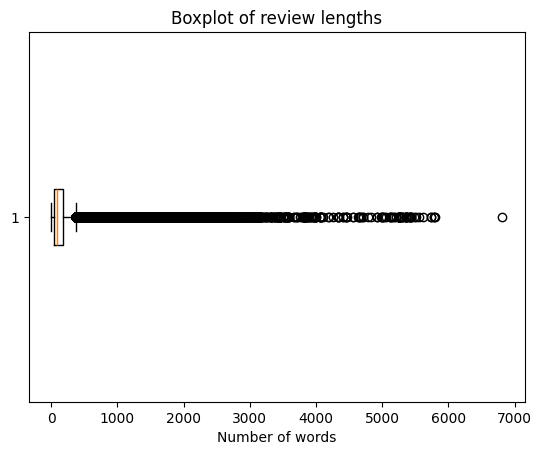

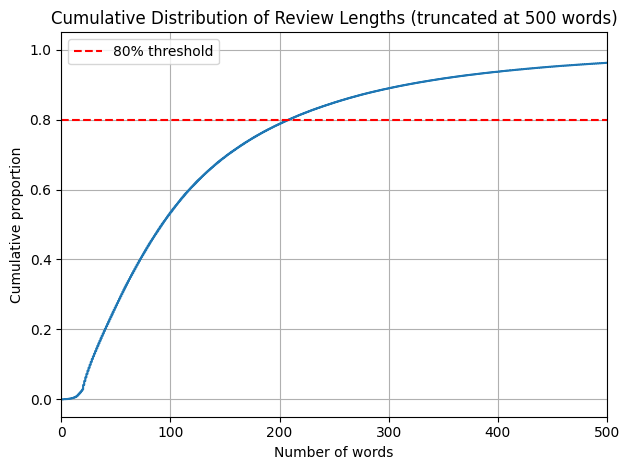

In [17]:
def word_count(text):
    return len(str(text).split())

review_lengths = df["review/text"].dropna().apply(word_count)

plt.hist(review_lengths, bins=50)
plt.xlabel("Number of words")
plt.ylabel("Number of reviews")
plt.title("Distribution of review lengths")

plt.savefig("distribution_of_review_lengths.png", dpi=300, bbox_inches='tight')  # PNG

plt.show()

plt.boxplot(review_lengths, vert=False)
plt.xlabel("Number of words")
plt.title("Boxplot of review lengths")
plt.savefig("box_plot_of_review_lengths.png", dpi=300, bbox_inches='tight')  # PNG
plt.show()

sorted_lengths = np.sort(review_lengths)
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
plt.plot(sorted_lengths, cumulative)
plt.axhline(0.8, color='r', linestyle='--', label='80% threshold')
plt.xlim(0, 500)  # sadece ilk 500 kelimeye kadar göster
plt.xlabel("Number of words")
plt.ylabel("Cumulative proportion")
plt.title("Cumulative Distribution of Review Lengths (truncated at 500 words)")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig("cumulative_review_length_500.png", dpi=300)
plt.show()

## Preprocessing the Text

In [18]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def decode_artifacts(text):
    if pd.isna(text): return ""
    text = html.unescape(text)
    text = unicodedata.normalize("NFKD", text)
    return text

df_cleaned = df[~df["review/text"].isna()]
df_cleaned.loc[:, "review/text"] = df_cleaned["review/text"].apply(decode_artifacts)
df_cleaned = df_cleaned[df_cleaned["review/text"].str.strip() != ""]

df_cleaned["word_count"] = df_cleaned["review/text"].apply(lambda x: len(x.split()))
df_cleaned = df_cleaned[df_cleaned["word_count"] >= 3]
df_cleaned = df_cleaned[df_cleaned["word_count"] <= 200]

df_cleaned["clean_text"] = df_cleaned["review/text"].apply(clean_text)
df_cleaned = df_cleaned.drop_duplicates(subset=["clean_text"])

df_cleaned = df_cleaned.reset_index(drop=True)

print(df_cleaned[["review/text", "word_count"]].head(10))

                                         review/text  word_count
0  This is only for Julie Strain fans. It's a col...          86
1  Theodor Seuss Giesel was best known as 'Dr. Se...          87
2  Trams (or any public transport) are not usuall...          63
3  I just finished the book, "Wonderful Worship i...         137
4  Many small churches feel like they can not hav...          55
5  I hadn't been a small church pastor very long ...         187
6  I bought this book because I read some glowing...         176
7  This is a self-published book, and if you want...         137
8  When I first read this the I was mezmerized at...          66
9  I read the review directly under mine and I ha...         143


## Sampling

In [19]:
df_sample = df_cleaned.sample(n=1000, random_state=42).reset_index(drop=True)

## Jaccard Similarity

In [24]:
def jaccard_similarity(str1, str2):
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:
        return 0.0
    return len(intersection) / len(union)

from tqdm import tqdm

similarities = []
n = len(df_sample)

for i in tqdm(range(n)):
    for j in range(i + 1, n):
        sim = jaccard_similarity(df_sample.loc[i, "clean_text"], df_sample.loc[j, "clean_text"])
        similarities.append((i, j, sim))

100%|██████████| 1000/1000 [00:12<00:00, 81.27it/s]


In [25]:
similarities_sorted = sorted(similarities, key=lambda x: x[2], reverse=True)
for i, j, score in similarities_sorted[:10]:
    print(f"\n[{i}] {df_sample.loc[i, 'review/text']}\n[{j}] {df_sample.loc[j, 'review/text']}\nSimilarity: {score:.2f}")
    


[288] A classic, terrific story, I would recommend it to anyone!
[468] I recommend it to anyone!!!
Similarity: 0.50

[430] The book was in good condition and it proved to be a valid transaction. I would recommend the seller.
[977] I received the book in good condition and in a timely manner
Similarity: 0.38

[430] The book was in good condition and it proved to be a valid transaction. I would recommend the seller.
[839] I received this book in the exact condition in which it was stated to be - excellent. And I received it in a very timely matter. I was very pleased with this purchase.
Similarity: 0.37

[839] I received this book in the exact condition in which it was stated to be - excellent. And I received it in a very timely matter. I was very pleased with this purchase.
[844] Great purchase Great purchase Great purchase Great purchase Great purchase and came when it was supposed to condition was also as stated I was very happy with this
Similarity: 0.37

[839] I received this book 

In [26]:
top_pairs = similarities_sorted[:100]
results = []

for i, j, score in top_pairs:
    results.append({
        "i": i,
        "j": j,
        "i_text": df_sample.loc[i, "review/text"],
        "j_text": df_sample.loc[j, "review/text"],
        "similarity": score
    })

results_df = pd.DataFrame(results)
results_df.to_csv("top_jaccard_pairs.csv", index=False)